<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_UPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте немного отвлечемся от тяжелых будней будущего нейронщика и вспомним, что в мире есть маленькие радости - а именно мультяшки. 

В этой работе: 
- скачайте датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip
- обучите VAE на данном датасете
- посмотрите качество воспроизведения мультяшек
- нагенерите мультяшек на свой вкус - оцените работу декодера

In [ ]:
# импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
from tensorflow.keras.preprocessing import image
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки
import gdown
import random

In [ ]:
# загрузка данных
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/1_VAE/cartoonset10k.zip', None, quiet=True)

# извлечение данных из архива
!unzip -q cartoonset10k.zip \*.png -d cartoon

In [ ]:
# Создаем пустой список для изображений
x_train = []

# Проходим по всем файлам в каталоге по указанному пути  
for filename in (os.listdir('./cartoon')):
    # получаем имя файла
    img_name = f'./cartoon/{filename}'
    # открываем картинку
    img = Image.open(img_name)
    # меняем размер
    new_img = img.resize((100, 100))
    # преобразуем в массив numpy
    im2arr = np.array(new_img)
    # добавляем в выборку
    x_train.append(im2arr)
x_train = np.array(x_train) 

In [ ]:
x_train = x_train.astype('float') / 255.

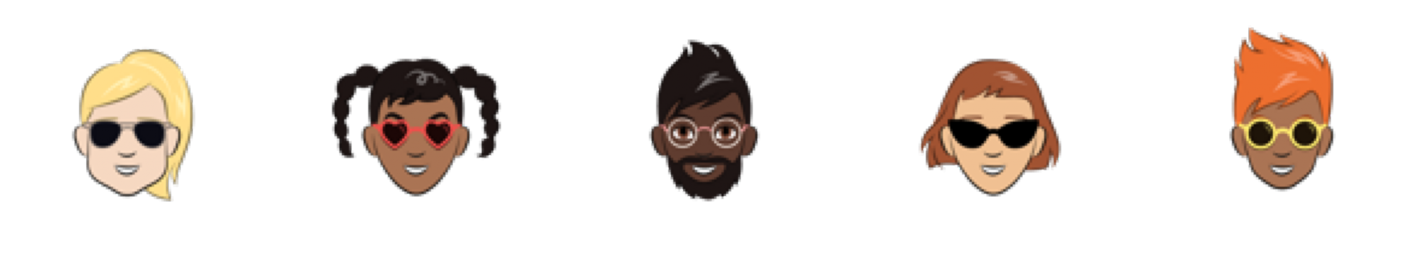

In [ ]:
# создаем полотно
plt.figure(figsize=(25, 8))
for i in range(5):
    # выбираем рандомно номер изображения
    img = random.randint(0, len(x_train))

    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[img])
    plt.axis('off')
plt.show()

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Создадим энкодер

# размер скрытого пространства
latent_dim = 200

# Добавим входной слой
encoder_inputs = keras.Input(shape=(100, 100, 4))

# Добавим сверточные слои
x = layers.Conv2D(64, (3,3), strides=1, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3,3), strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Добавим Flatten
x = layers.Flatten()(x)

# Добавим dense
x = layers.Dense(latent_dim, activation='linear')(x)

# Добавим dense для формирования мат.ожидания
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# Добавим dense для формирования логарифма дисперсии
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# Добавим слой генерации случайных изображений
z = Sampling()([z_mean, z_log_var])

# Соберем модель энкодера
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Выведем состав энкодера
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Создадим декодер

# Добавим входной слой
latent_inputs = keras.Input(shape=(latent_dim,))

# Добавим dense
x = layers.Dense(25 * 25 * 64)(latent_inputs)
x = layers.LeakyReLU()(x)
x = layers.Reshape((25, 25, 64))(x)

# Добавим обратную свертку
x = layers.Conv2DTranspose(128, (3,3), padding="same", strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3), padding="same", strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, (3,3), padding="same", strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_outputs = layers.Conv2DTranspose(4, (3,3), activation="sigmoid", padding="same")(x)

# Соберем декодер
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# Выведем состав декодера
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 40000)             8040000   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 40000)             0         
                                                                 
 reshape (Reshape)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 25, 128)      73856     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 128)      512       
 hNormalization)                                           

In [ ]:
# Создадим класс вариационного автокодировщика

class VAE(keras.Model):
    
    # конcтруктор класса
    def __init__(self, encoder, decoder, **kwargs):
        # Подаем скомпилирование энкодер и декодер
        # Инициализируем класс - предок
        super(VAE, self).__init__(**kwargs)
        # Заполняем поле encoder
        self.encoder = encoder
        # Заполняем поле decoder
        self.decoder = decoder
        #Указываем лоссы для total_loss_tracker
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        #Указываем лоссы для reconstruction_loss_tracker
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        #Указываем лоссы для вычисления дивергенции  Кульбака-Лейблера
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Определяем метод metrics
    @property
    def metrics(self):                              

        # Вернем список лоссов
        return [self.total_loss_tracker, self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    # Создадим метод train_step
    def train_step(self, data):   

        # Создаем ленту градиентов
        with tf.GradientTape() as tape:  

            # Получим выход энкодера - точка в скрытом слое
            z_mean, z_log_var, z = self.encoder(data)  

            # Получим восстановленное изображение
            reconstruction = self.decoder(z)

            # Вычислим ошибку восстановления изображения
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # Вычислим ошибку Кульбака - Лейблера
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Вычислим суммарную ошибку на шаге
            total_loss = reconstruction_loss + kl_loss

        # Рассчитаем градиенты    
        grads = tape.gradient(total_loss, self.trainable_weights)

        # Корректируем веса модели
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Пересчитаем общий лосс
        self.total_loss_tracker.update_state(total_loss)

        # Пересчитаем лосс восстановления изображеня
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        # Пересчитаем лосс Кульбака-Лейблера
        self.kl_loss_tracker.update_state(kl_loss)

        # Вернем словарь значений лоссов
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Создаем экземпляр класса автокодировщика
vae = VAE(encoder, decoder)

# Компилируем модель
vae.compile(optimizer=keras.optimizers.Adam()) 

# Обучаем автокодировщик
vae.fit(x_train, epochs=30, batch_size=100)

Epoch 1/30
100/100 [==============================] - 31s 209ms/step - loss: 2869.1830 - reconstruction_loss: 1887.7434 - kl_loss: 56.4376
Epoch 2/30
100/100 [==============================] - 21s 209ms/step - loss: 1367.3523 - reconstruction_loss: 1272.3568 - kl_loss: 62.2406
Epoch 3/30
100/100 [==============================] - 21s 209ms/step - loss: 1276.3712 - reconstruction_loss: 1197.7222 - kl_loss: 60.9466
Epoch 4/30
100/100 [==============================] - 21s 209ms/step - loss: 1221.2803 - reconstruction_loss: 1159.5430 - kl_loss: 56.8091
Epoch 5/30
100/100 [==============================] - 21s 209ms/step - loss: 1194.6249 - reconstruction_loss: 1139.2842 - kl_loss: 54.2059
Epoch 6/30
100/100 [==============================] - 21s 209ms/step - loss: 1181.6873 - reconstruction_loss: 1124.4695 - kl_loss: 50.9516
Epoch 7/30
100/100 [==============================] - 21s 209ms/step - loss: 1163.9738 - reconstruction_loss: 1112.2939 - kl_loss: 47.8028
Epoch 8/30
100/100 [=======

In [ ]:
# функция для вывода изображений
def plotImages(xTrain, shape=(100, 100, 4)):
    # зададим количество картинок, сколько хотим показать
    n = 7
    plt.figure(figsize=(30, 10))
    for i in range(n):
        index = np.random.randint(0, xTrain.shape[0])
        # Показываем картинки из тестового набора
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xTrain[index].reshape(shape))
        ax.set_title('Оригинальные мультяшки')
        # plt.gray()
        # скрываем выводы координатных осей
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показываем восстановленные картинки
        ax = plt.subplot(2, n, i + 1 + n)
        img = np.expand_dims(x_train[index], axis=0)
        z_mean, z_log_var, z = vae.encoder.predict(x=img)
        gen_test = vae.decoder.predict(x=z)
        plt.imshow((gen_test[0] * 255).astype(np.uint8))
        ax.set_title('Сгенерированные мультяшки')
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

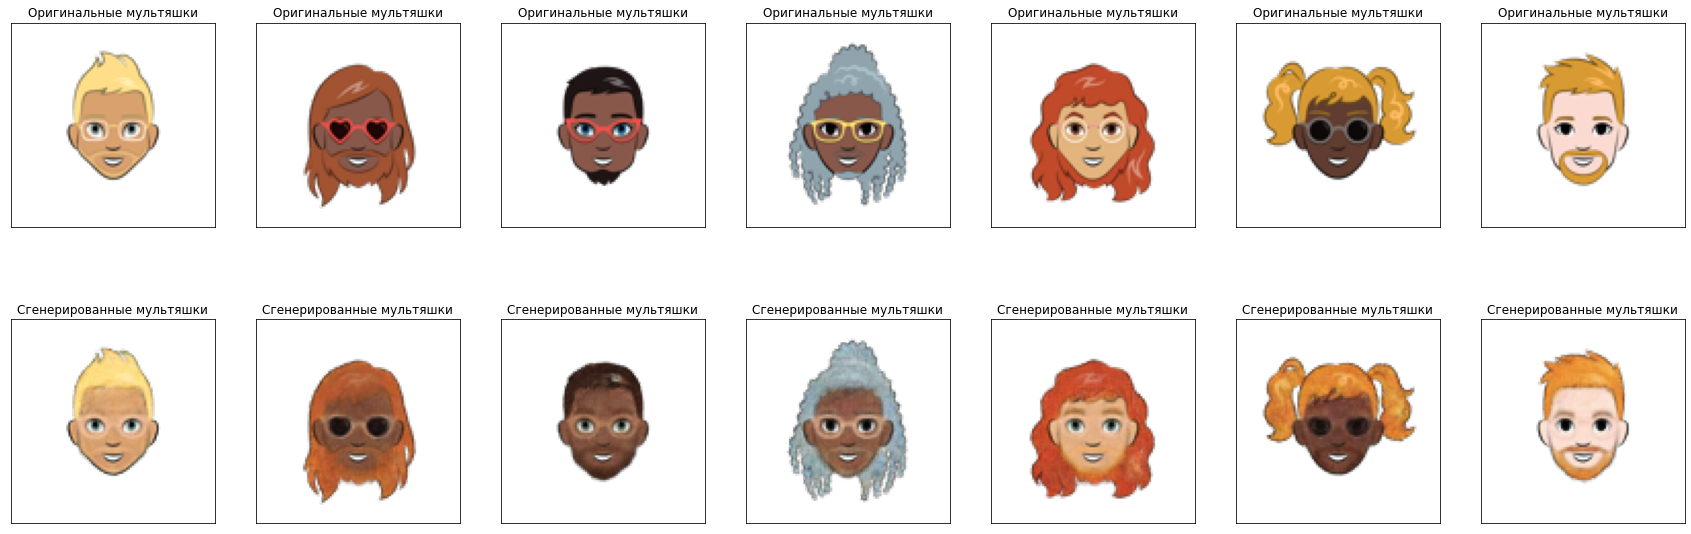

In [ ]:
plotImages(x_train)

Некоторым лицам убрали очки, некоторым поменяли форму очков, поработали с ресницами, бородой и усами.